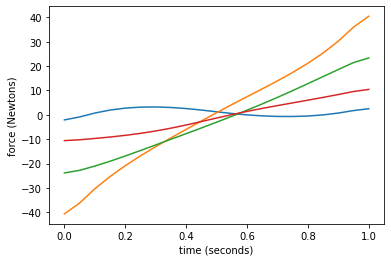

In [3]:
#sgillen: implementation of trajectory optimization using the five link walker


# jupyter magic 
#==============================================================================

#%load_ext line_profiler

#%lprun -f __main__ __main__()


# imports
#==============================================================================

import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger, 
                         Isometry3, DirectCollocation, PiecewisePolynomial)
from pydrake.solvers.mathematicalprogram import Solve

from pydrake.attic.multibody.shapes import VisualElement, Box
from pydrake.attic.multibody.collision import CollisionElement

#from pydrake.all import 
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML

#this one is home grown, make sure it's in the same directory as this notebook
from seagul.drake import x_expr,y_expr,x_float,y_float,x_taylor,y_taylor
from seagul.resources import getResourcePath 


#define some constants
#==============================================================================
pi = math.pi


#set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link.urdf"), FloatingBaseType.kFixed)


box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")

tree.compile()

plant = RigidBodyPlant(tree)
context = plant.CreateDefaultContext()

# set up the mathematical program , in this case direct collocation
#==============================================================================

num_time_samples = 21
dircol = DirectCollocation(plant, context, num_time_samples = num_time_samples,
                           minimum_timestep=0.05, maximum_timestep=0.05)

#add constraints
#------------------------------------------------------------------------------
dircol.AddEqualTimeIntervalsConstraints()

dircol.AddLinearConstraint(dircol.initial_state()[0] - pi == -(dircol.final_state()[0] - pi))
dircol.AddLinearConstraint(dircol.initial_state()[1] ==  -dircol.final_state()[4])
dircol.AddLinearConstraint((dircol.initial_state()[0] + dircol.initial_state()[1] + dircol.initial_state()[2]) ==  (dircol.final_state()[0] + dircol.final_state()[1] + dircol.final_state()[2]))
dircol.AddLinearConstraint(2*pi - dircol.initial_state()[3] == dircol.final_state()[3])
dircol.AddLinearConstraint(dircol.initial_state()[4] == -dircol.final_state()[1])

dircol.AddLinearConstraint(dircol.initial_state()[5]  == -(dircol.final_state()[5]))
dircol.AddLinearConstraint(dircol.initial_state()[6] ==  - dircol.final_state()[6])
dircol.AddLinearConstraint(dircol.initial_state()[7] + dircol.initial_state()[6] + dircol.initial_state()[5] == dircol.final_state()[7] + dircol.initial_state()[6] + dircol.initial_state()[5])
dircol.AddLinearConstraint(dircol.initial_state()[8] == - dircol.final_state()[8])
dircol.AddLinearConstraint(dircol.initial_state()[9] == -dircol.final_state()[9])

#there is probably a way to have rigid body tree calculate these quantities, but when I tried it did not work at all and this was pretty fast...
x5_in = x_expr(dircol.initial_state())
x5_fn = x_expr(dircol.final_state())

y5_in = y_expr(dircol.initial_state())
y5_fn = y_expr(dircol.final_state())

dircol.AddConstraint(x5_in <= -1)
dircol.AddConstraint(x5_fn >= 1)

dircol.AddConstraint(y5_fn == 0)
dircol.AddConstraint(y5_in == 0)

#Add costs
#------------------------------------------------------------------------------

R = 10  # Cost on input "effort".
u = dircol.input()

dircol.AddRunningCost(R*u[0]**2)
dircol.AddRunningCost(R*u[1]**2)
dircol.AddRunningCost(R*u[2]**2)
dircol.AddRunningCost(R*u[3]**2)

for i in range(0,num_time_samples):
    dircol.AddCost((y_taylor(dircol.state(i), 4) - .2))
    
dircol.AddFinalCost(dircol.time())

#Add initial trajectory for the solver
#------------------------------------------------------------------------------

initial_state = (pi - pi/8,    0 , -3*pi/4 - (pi - pi/8) ,  2*pi -( pi/2 + pi/4) ,0, 0,0, 0,0,0)  # initial condition
final_state =   (pi + pi/8,    0 , -3*pi/4 - (pi + pi/8),  3*pi/4 ,0, 0 , 0, 0, 0, 0)  # final condition

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0., 4.], np.column_stack((initial_state, final_state)))
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)


#solve the nonlinear program
#==============================================================================

result = Solve(dircol)
print(result)
#assert(result == SolutionResult.kSolutionFound)


#parse and plot the results
#==============================================================================
x_trajectory = dircol.ReconstructStateTrajectory(result)


u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)

u_lookup = np.vectorize(u_trajectory.value)
u_values = np.zeros((times.size,4),float)
for i,t in enumerate(times):
    u_values[i,:] = np.transpose(u_lookup(t))


x_lookup = np.vectorize(x_trajectory.value)
x_values = np.zeros((times.size,10),float)
for i,t in enumerate(times):
    x_values[i,:] = np.transpose(x_lookup(t))
    
plt.figure()
plt.plot(times, u_values)
plt.xlabel('time (seconds)')
plt.ylabel('force (Newtons)')

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-1, 2.5])
ani = prbv.animate(x_trajectory, resample=100, repeat=True)
plt.close(prbv.fig)
HTML(ani.to_html5_video())

In [ ]:
#state_dict = {}
#for i,state in enumerate(dircol.final_state()):
#    state_dict[state] = x_trajectory.value(-1)[i]
#    print x_trajectory(-1)[i]
    
#state_dict = {}
#for i,state in enumerate(dircol.final_state()):
#    state_dict[state] = initial_state[i]
#    print final_state[i]
 
for i, time in enumerate(times):
    print x_float(x_trajectory.value(time))
    
    
endt = times[-1]

print "intitial_values"
print x_trajectory.value(endt)
  
    
print "final_values"
print x_trajectory.value(0)

    
print "angles"

print x_trajectory.value(endt)[0] + x_trajectory.value(endt)[1] + x_trajectory.value(endt)[2]

print x_trajectory.value(0)[0] + x_trajectory.value(0)[1] + x_trajectory.value(0)[2]

#print x_trajectory.value(1)

#print "x,y"
#print "x1 = ", x1_fn.Evaluate(state_dict)
#print "x2 = ", x2_fn.Evaluate(state_dict)
#print "x4 = ", x4_fn.Evaluate(state_dict)
#print "x5 = ", x5_fn.Evaluate(state_dict)


In [ ]:
y_vals = np.empty([100])

for i,time in enumerate(times):
    #print (x_trajectory.value(time))
    #print y_float(x_trajectory.value(time))
    #y_vals.append(y_float(x_trajectory.value(time)))
    y_vals[i] = y_float(x_trajectory.value(time))
    
#print y_vals
plt.plot(y_vals)
print all(i >= 0 for i in y_vals)
print min(y_vals)

/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/ipykernel_launcher.py:64: DrakeDeprecationWarning: '_DeclarePeriodicPublish' is deprecated and will be removed on or around 2019-08-01. Please call 'DeclarePeriodicPublish' instead.
    Please see `help(pydrake.common.deprecation)` for more information.


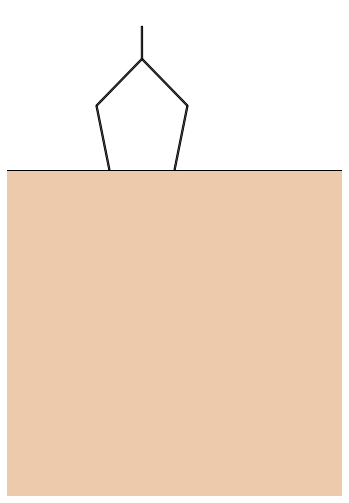

In [6]:
#sgillen: implementation of trajectory optimization using the five link walker


# jupyter magic 
#==============================================================================

#%load_ext line_profiler

#%lprun -f __main__ __main__()


# imports
#==============================================================================

import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator,SignalLogger, 
                         Isometry3, DirectCollocation, PiecewisePolynomial,
                         VectorSystem)

from pydrake.solvers.mathematicalprogram import Solve

from pydrake.attic.multibody.shapes import VisualElement, Box
from pydrake.attic.multibody.collision import CollisionElement

#from pydrake.all import 
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from IPython.display import HTML

#this one is home grown, make sure it's in the same directory as this notebook
from seagul.drake import x_expr,y_expr,x_float,y_float,x_taylor,y_taylor
from seagul.resources import getResourcePath 


#define some constants
#==============================================================================
pi = math.pi


#set up the walker and the ground
#==============================================================================

#load the walker 
tree = RigidBodyTree(FindResource(getResourcePath() + "/five_link.urdf"), FloatingBaseType.kFixed)


box_depth = 100
X = Isometry3(rotation=np.identity(3), translation=[0, 0, -5.])
                
color = np.array([0.9297, 0.7930, 0.6758, 1])
tree.world().AddVisualElement(VisualElement(Box([100., 1., 10.]), X, color))
tree.addCollisionElement(CollisionElement(Box([100., 1., 10.]), X), tree.world(), "the_ground")

tree.compile()

builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))

logger = builder.AddSystem(SignalLogger(robot.get_output_port(0).size()))
logger._DeclarePeriodicPublish(1.0 / 30.0, 0.0)

controller = builder.AddSystem(tracking_controller(u_lookup))
builder.Connect(robot.get_output_port(0), logger.get_input_port(0))
builder.Connect(robot.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), robot.get_input_port(0))

diagram = builder.Build()

simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

context = simulator.get_mutable_context()
state = context.get_mutable_continuous_state_vector()
state.SetFromVector(x_lookup(0))  # initial condition

simulator.StepTo(3)

prbv = PlanarRigidBodyVisualizer(tree, xlim=[-2.5, 2.5], ylim=[-5, 2.5])
ani = prbv.animate(logger, repeat=True)
# plt.close(prbv.fig)
HTML(ani.to_html5_video())

In [ ]:
builder = DiagramBuilder

In [ ]:
%store u_values

In [5]:
class tracking_controller(VectorSystem):
    def __init__(self, traj):
        VectorSystem.__init__(self,10,4)
        self.traj = traj
    def DoCalcVectorOutput(self, context, state, _ , output):
        #import ipdb; ipdb.set_trace()
        u = self.traj(context.get_time()).squeeze()
        output[:] = u
        